**KMeans Clustering**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

C:\Users\aorfa\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('../clean_data/full_merged_data.csv')
df.drop(columns=['FIPS', 'Booster_Doses_Vax_Pct_030121', 'Booster_Doses_Vax_Pct_090121', 'null_pct'], inplace=True)
df.dropna(inplace=True)
#df = data[(data['Dose1_Pop_Pct_030122'] > 0) & (data['Dose1_Pop_Pct_090121'] > 0)].copy()

## Final Preprocessing

### Examine where there are 0s in the vax data

In [3]:
# Rows with zeros in vax data

df[(df['Dose1_Pop_Pct_030121'] == 0) | (df['Dose1_Pop_Pct_090121'] == 0) | (df['Dose1_Pop_Pct_030122'] == 0) | (df['Series_Complete_Pop_Pct_090121'] == 0) | (df['Series_Complete_Pop_Pct_030122'] == 0)]

,County_State,pct_hesitant_02-24-22,pct_somewhat_hesitant_02-24-22,pct_highly_hesitant_02-24-22,uninsured_pct,socio_wgt,hh_wgt,minority_wgt,housing_wgt,overall_wgt,...,Census2019_65PlusPop,Census2019_18to64Pop,state,candidate_won,pct_trump,pct_biden,hesitant_x_nzip,somewhat_hesitant_x_nzip,highly_hesitant_x_nzip,Census2019_Pct_65Plus
15,adams_ne,0.279,0.075,0.204,0.070038,0.419250,0.553167,0.373541,0.481724,0.432931,...,5916.0,18104.0,NE,1.0,0.688,0.312,3.348,0.900,2.448,0.188630
53,alpine_ca,0.122,0.032,0.089,0.102967,0.731800,0.776300,0.467700,0.905400,0.819700,...,298.0,631.0,CA,0.0,0.358,0.642,0.366,0.096,0.267,0.263950
63,anderson_tx,0.352,0.065,0.287,0.107789,0.602553,0.557233,0.566100,0.626916,0.618462,...,8658.0,38097.0,TX,1.0,0.786,0.214,3.520,0.650,2.870,0.149961
65,andrews_tx,0.170,0.093,0.077,0.181221,0.566261,0.307379,0.817321,0.631945,0.621314,...,1833.0,11069.0,TX,1.0,0.843,0.157,0.170,0.093,0.077,0.097995
67,angelina_tx,0.313,0.074,0.239,0.187542,0.717027,0.852157,0.596047,0.670666,0.777134,...,14422.0,50236.0,TX,1.0,0.725,0.275,1.878,0.444,1.434,0.166315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183,york_ne,0.251,0.055,0.196,0.064642,0.301035,0.584676,0.271438,0.591781,0.412412,...,2860.0,7642.0,NE,1.0,0.745,0.255,2.510,0.550,1.960,0.209080
3187,young_tx,0.260,0.107,0.153,0.182897,0.521612,0.814959,0.458777,0.681379,0.653761,...,3774.0,9975.0,TX,1.0,0.863,0.137,1.560,0.642,0.918,0.209550
3191,yuma_co,0.232,0.062,0.170,0.111034,0.487928,0.712810,0.652603,0.813721,0.709644,...,1872.0,5402.0,CO,1.0,0.825,0.175,2.320,0.620,1.700,0.186845
3192,zapata_tx,0.131,0.044,0.087,0.292713,0.896325,0.893859,0.977769,0.717132,0.954960,...,1866.0,7625.0,TX,1.0,0.525,0.475,0.655,0.220,0.435,0.131603


In [4]:

zero_march21 = df[df['Dose1_Pop_Pct_030121'] == 0.0]
zero_sept21 = df[df['Dose1_Pop_Pct_090121'] == 0.0]
zero_march22 = df[df['Dose1_Pop_Pct_030122'] == 0.0]

print(f'zeros march21: {zero_march21.shape[0]}')
print(f'zeros sept21: {zero_sept21.shape[0]}')
print(f'zeros march22: {zero_march22.shape[0]}')

zeros march21: 340
zeros sept21: 418
zeros march22: 85


In [5]:
zero_complete_march21 = df[df['Series_Complete_Pop_Pct_030121'] == 0.0]
zero_complete_sept21 = df[df['Series_Complete_Pop_Pct_090121'] == 0.0]
zero_complete_march22 = df[df['Series_Complete_Pop_Pct_030122'] == 0.0]

print(f'zeros march21: {zero_march21.shape[0]}')
print(f'zeros sept21: {zero_sept21.shape[0]}')
print(f'zeros march22: {zero_march22.shape[0]}')

zeros march21: 340
zeros sept21: 418
zeros march22: 85


In [6]:
# Add binary features for missing data at each checkpoint date
# Checked to make sure that all counties missing Series Complete data for a given date are also missing Dose1 for that date
df['Missing_March21'] = df['Dose1_Pop_Pct_030121'].map(lambda x: x == 0).astype(int)
df['Missing_Sept21'] = df['Dose1_Pop_Pct_090121'].map(lambda x: x == 0).astype(int)
df['Missing_March22'] = df['Dose1_Pop_Pct_030122'].map(lambda x: x== 0).astype(int)

In [7]:
# Imputing vax checkpoints for Sept 21 as mean of March 21 and March 22

df['Mar21_22_Dose1_Avg'] = (df['Dose1_Pop_Pct_030121'] + df['Dose1_Pop_Pct_030122']) / 2
df['Mar21_22_Complete_Avg'] = (df['Dose1_Pop_Pct_030121'] + df['Dose1_Pop_Pct_030122']) / 2

df['Dose1_Pop_Pct_090121_impute'] = df['Dose1_Pop_Pct_090121'].replace(0, np.nan).fillna(df['Mar21_22_Dose1_Avg'])
df['Series_Complete_Pop_Pct_090121_impute'] = df['Series_Complete_Pop_Pct_090121'].replace(0, np.nan).fillna(df['Mar21_22_Complete_Avg'])

df.drop(columns=['Mar21_22_Complete_Avg', 'Mar21_22_Dose1_Avg'], inplace=True)

In [8]:
# % zeros by state
# March 21
zero_march21['state'].value_counts(normalize=True)

TX    0.747059
CO    0.082353
VA    0.044118
NM    0.041176
NE    0.029412
CA    0.023529
SD    0.011765
HI    0.011765
ID    0.002941
MA    0.002941
MT    0.002941
Name: state, dtype: float64

In [9]:
# Sept 21
zero_sept21['state'].value_counts(normalize=True)

TX    0.607656
NE    0.141148
SD    0.088517
OH    0.055024
NM    0.038278
MI    0.023923
CA    0.019139
VA    0.016746
HI    0.009569
Name: state, dtype: float64

In [10]:
zero_march22['state'].value_counts(normalize=True)

NE    0.682353
VA    0.105882
CA    0.094118
HI    0.047059
MA    0.035294
TX    0.023529
MI    0.011765
Name: state, dtype: float64

In [11]:
no_data_post321 = df[(df['Dose1_Pop_Pct_030122'] == 0) & (df['Dose1_Pop_Pct_090121'] == 0)].copy().index
reporting = df.drop(no_data_post321)
reporting.shape

(3064, 35)

In [12]:
df.shape

(3138, 35)

In [13]:
# How many Texas counties?
df[df['state'] =='TX'].shape

(254, 35)

In [14]:
reporting[reporting['state'] == 'TX'].shape

# All but 2 texas counties *did* report data after March '21

(252, 35)

In [15]:
# How many Nebraska counties?
df[df['state'] =='NE'].shape

(93, 35)

In [16]:
reporting[reporting['state'] == 'NE'].shape

# only about 1/3 of nebraska counties reported data after march '21

(39, 35)

In [17]:
df.columns

Index(['County_State', 'pct_hesitant_02-24-22',
       'pct_somewhat_hesitant_02-24-22', 'pct_highly_hesitant_02-24-22',
       'uninsured_pct', 'socio_wgt', 'hh_wgt', 'minority_wgt', 'housing_wgt',
       'overall_wgt', 'Dose1_Pop_Pct_030121', 'Series_Complete_Pop_Pct_030121',
       'Dose1_Pop_Pct_090121', 'Series_Complete_Pop_Pct_090121',
       'Dose1_Pop_Pct_030122', 'Series_Complete_Pop_Pct_030122',
       'Booster_Doses_Vax_Pct_030122', 'SVI_CTGY', 'Metro_status',
       'Census2019', 'Census2019_65PlusPop', 'Census2019_18to64Pop', 'state',
       'candidate_won', 'pct_trump', 'pct_biden', 'hesitant_x_nzip',
       'somewhat_hesitant_x_nzip', 'highly_hesitant_x_nzip',
       'Census2019_Pct_65Plus', 'Missing_March21', 'Missing_Sept21',
       'Missing_March22', 'Dose1_Pop_Pct_090121_impute',
       'Series_Complete_Pop_Pct_090121_impute'],
      dtype='object')

In [18]:
# Rename Columns
rename_dict = {#'County_State':'County_State', 
                   'pct_hesitant_02-24-22':'Pct_Hesitant_Feb22',
                   'pct_somewhat_hesitant_02-24-22': 'Pct_Somewhat_Hesitant_Feb22', 
                   'pct_highly_hesitant_02-24-22': 'Pct_Highly_Hesitant_Feb22',
                   'uninsured_pct': 'Pct_Uninsured', 
                   'socio_wgt': 'SVI_Socio', 
                   'hh_wgt': 'SVI_HHDisab', 
                   'minority_wgt': 'SVI_Minority',
                   'housing_wgt': 'SVI_HousingTransp', 
                   'overall_wgt': 'SVI_Overall', 
                  # 'Dose1_Pop_Pct_030121': 'Dose1_Pop_Pct_030121',
                  # 'Series_Complete_Pop_Pct_030121': 'Series_Complete_Pop_Pct_030121', 
                  # 'Dose1_Pop_Pct_090121': 'Dose1_Pop_Pct_090121',
                  # 'Series_Complete_Pop_Pct_090121', 
                  # 'Dose1_Pop_Pct_030122',
                  # 'Series_Complete_Pop_Pct_030122',
                   #'Booster_Doses_Vax_Pct_030122',
                   'SVI_CTGY': 'SVI_Ctgy', 
                   'Metro_status': 'Metro_Status', 
                  # 'Census2019':, 
                  # 'Census2019_65PlusPop',
                  # 'Census2019_18to64Pop', 
                   'state':'State', 
                   'candidate_won': 'Candidate_Won', 
                   'pct_trump': 'Pct_Trump', 
                   'pct_biden': 'Pct_Biden', 
                   'hesitant_x_nzip': 'Hesitant_nzip', 
                   'somewhat_hesitant_x_nzip': 'Somewhat_Hesitant_nzip',
                   'highly_hesitant_x_nzip': 'Highly_Hesitant_nzip', 
                  # 'Census2019_Pct_65Plus', 
                   #'Missing_March21',
                   #'Missing_Sept21', 
                  # 'Missing_March22', 
                  # 'Dose1_Pop_Pct_090121_impute',
                  # 'Series_Complete_Pop_Pct_090121_impute'
}
df.rename(columns=rename_dict, inplace=True)

In [19]:
df.to_csv('../clean_data/final_data_formodeling.csv')

## Model #1

In [20]:
feat = ['Pct_Hesitant_Feb22', 'Pct_Somewhat_Hesitant_Feb22',
       'Pct_Highly_Hesitant_Feb22', 
       'Dose1_Pop_Pct_030121',
        'Dose1_Pop_Pct_090121_impute',
        'Dose1_Pop_Pct_030122',
        'Series_Complete_Pop_Pct_090121_impute',
       'Series_Complete_Pop_Pct_030122', 
        'Booster_Doses_Vax_Pct_030122',
        'Missing_Sept21', 
       'SVI_Overall',
        'Metro_Status', 
       'Census2019_Pct_65Plus']

In [21]:
# Leave all vax data, including 0s

X = df[feat]

ss = StandardScaler()
X_sc = ss.fit_transform(X)
X.columns

Index(['Pct_Hesitant_Feb22', 'Pct_Somewhat_Hesitant_Feb22',
       'Pct_Highly_Hesitant_Feb22', 'Dose1_Pop_Pct_030121',
       'Dose1_Pop_Pct_090121_impute', 'Dose1_Pop_Pct_030122',
       'Series_Complete_Pop_Pct_090121_impute',
       'Series_Complete_Pop_Pct_030122', 'Booster_Doses_Vax_Pct_030122',
       'Missing_Sept21', 'SVI_Overall', 'Metro_Status',
       'Census2019_Pct_65Plus'],
      dtype='object')

In [22]:
# Try different values of n_clusters using elbow plots

# Inertia
inertia_list = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sc)
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(1, 10), inertia_list, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Inertia Scores');

AttributeError: 'NoneType' object has no attribute 'split'

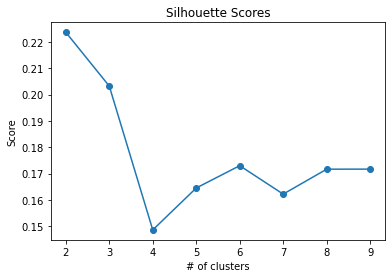

In [24]:
# Silhouette Score
silhouette_list = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sc)
    silhouette_list.append(silhouette_score(X_sc, kmeans.labels_))

plt.plot(range(2,10), silhouette_list, marker = 'o')
plt.xlabel('# of clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores')
plt.savefig('../Graphs/Silhouette Score.png')

In [ ]:
# Proceed with 3 clusters

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_sc)

df['Cluster'] = kmeans.labels_
df['Cluster'].value_counts(normalize=True)

In [ ]:
# score the model
print(f'inertia: {kmeans.inertia_}')
print(f'silhouette score {silhouette_score(X_sc, kmeans.labels_)}')

## Understanding Model Results

In [ ]:
# Cluster frequencies by state
pd.get_dummies(df, columns=['Cluster'])[['State', 'Cluster_0', 'Cluster_1', 'Cluster_2']].groupby('State').sum().sort_values('Cluster_0', ascending=False)

In [ ]:
# Cluster means in model features
df.groupby('Cluster').mean()[feat].T

In [ ]:
# Cluster means for other features
df.groupby('Cluster').mean()[['Missing_March21', 'Missing_Sept21', 'Missing_March22', 'SVI_Minority', 'SVI_Socio', 'Pct_Trump', 'Candidate_Won']].T

In [ ]:
# Baseline Trump victory rate
df[['Candidate_Won']].mean()

In [ ]:
# Total population in each cluster
df.groupby('Cluster')[['Census2019']].sum().T

**Summary of observations from clustering model:**

*Cluster 0*

- These counties have the highest vaccine hesitancy, but their vaccination rates are in the middle of the pack. This could be due to Cluster 2's vaccination averages being brought down by non-reporting.
- These counties are generally rural (metro status=0); their social vulnerability is high as measured by socioeconomic status and about the same overall as Cluster 2's.
- Trump won the election in 94.8% of these counties, the highest percent among all the clusters.
- Overall this cluster appears demographically and politically similar to Cluster 2.

*Cluster 1*

- These counties have the lowest hesitancy and highest vaccination rates overall.
- These counties are most urban (metro status=1) on average and comprise the largest total population (about 5x the population of Cluster 0 and 8x the population of Cluster 2).
- These counties have the lowest social vulnerability rankings overall and by socioeconomic status, but they contain more minority population than Cluster 0.
- These counties had the lowest rates of voting for Trump, with Trump victory occurring in 64% of counties compared to 83% nationwide.

*Cluster 2*

- Most counties that did not report vaccination data are in this cluster. Nearly half of these counties are in Texas.
- Possibly due to non-reporting, these counties' vaccination rates are the lowest. The hesitancy rates (17.8% on average are highly hesitant), however, support the hypothesis that vaccination efforts have in fact faced barriers in these counties.
- These counties have the highest social based on minority status, but comparable overall social vulnerability to Cluster 0.
- These counties had an above-average rate of Trump election victory, but not as high a rate as Cluster 0.


## Visualizing Clusters

In [ ]:
df['color'] = df['Cluster'].map({0:'#00919C', 1:'#E8B44F', 2:'#BE5504'})

plt.figure(figsize=(10,8))
plt.scatter(df['Dose1_Pop_Pct_090121_impute'], df['Pct_Hesitant_Feb22'], c=df['color'], alpha=.6)
pop_a = mpatches.Patch(color='#00919C', label='Cluster 0')
pop_b = mpatches.Patch(color='#E8B44F', label='Cluster 1')
pop_c = mpatches.Patch(color='#BE5504', label='Cluster 2')
plt.legend(handles=[pop_a,pop_b, pop_c])

plt.xlabel('Percent with one vaccine dose 9/1/21')
plt.ylabel('Percent hesitant 2/24/21')
plt.title('Vaccination and Hesitancy, showing KMeans clusters')
plt.savefig('../graphs/cluster_onevax_hesitant.png', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(df['Series_Complete_Pop_Pct_090121_impute'], df['Pct_Trump'], c=df['color'], alpha=.6)

pop_a = mpatches.Patch(color='#00919C', label='Cluster 0')
pop_b = mpatches.Patch(color='#E8B44F', label='Cluster 1')
pop_c = mpatches.Patch(color='#BE5504', label='Cluster 2')
plt.legend(handles=[pop_a,pop_b, pop_c])

plt.xlabel('Percent fully vaccinated by 9/1/21')
plt.ylabel('Percent voted for Trump')
plt.title('Vaccination and 2020 voting, showing KMeans clusters')
plt.savefig('../graphs/cluster_fullvax_hesitant.png', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(df['SVI_Overall'], df['Pct_Trump'], c=df['color'], alpha=.6)

pop_a = mpatches.Patch(color='#00919C', label='Cluster 0')
pop_b = mpatches.Patch(color='#E8B44F', label='Cluster 1')
pop_c = mpatches.Patch(color='#BE5504', label='Cluster 2')
plt.legend(handles=[pop_a,pop_b, pop_c])

plt.xlabel('Overall SVI percentile')
plt.ylabel('Percent voted for Trump')
plt.title('SVI and Presidential Election Results, showing KMeans clusters')
plt.savefig('../graphs/cluster_svi_trump.png', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(df['Census2019_Pct_65Plus'], df['Pct_Trump'], c=df['color'], alpha=.5)

pop_a = mpatches.Patch(color='#00919C', label='Cluster 0')
pop_b = mpatches.Patch(color='#E8B44F', label='Cluster 1')
pop_c = mpatches.Patch(color='#BE5504', label='Cluster 2')
plt.legend(handles=[pop_a,pop_b, pop_c])

plt.xlabel('Percent of population over 65')
plt.ylabel('Percent voted for Trump')
plt.title('Over-65 Population and 2020 Election Results, showing KMeans clusters')
plt.savefig('../graphs/cluster_65plus_trump.png', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');

In [ ]:
cluster0 = df[df['Cluster'] == 0]
cluster1 = df[df['Cluster'] == 1]
cluster2 = df[df['Cluster'] == 2]

plt.figure(figsize=(8,6))

plt.hist(cluster0['Dose1_Pop_Pct_030121'], alpha=.5, bins=20, color='#00919C')
plt.axvline(cluster0['Dose1_Pop_Pct_030121'].mean(), color='#00919C')

plt.hist(cluster1['Dose1_Pop_Pct_030121'], alpha=.5, bins=20, color='#E8B44F')
plt.axvline(cluster1['Dose1_Pop_Pct_030121'].mean(), color='#E8B44F')

plt.hist(cluster2['Dose1_Pop_Pct_030121'], alpha=.5, bins=20, color='#BE5504')
plt.axvline(cluster2['Dose1_Pop_Pct_030121'].mean(), color='#BE5504')

#plt.xticks(range(0, 110, 10))
#plt.legend()
plt.title('Histogram of Vaccination Rates in March 2021 by Cluster')
plt.xlabel('Percent of population that received at least one vaccine dose')
plt.ylabel('Frequency')
plt.savefig('../graphs/cluster_0321_onevax.png', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');

In [ ]:
plt.figure(figsize=(8,6))

plt.hist(cluster0['Dose1_Pop_Pct_090121_impute'], alpha=.5, bins=20, color='#00919C')
plt.axvline(cluster0['Dose1_Pop_Pct_090121_impute'].mean(), color='#00919C')

plt.hist(cluster1['Dose1_Pop_Pct_090121_impute'], alpha=.5, bins=20, color='#E8B44F')
plt.axvline(cluster1['Dose1_Pop_Pct_090121_impute'].mean(), color='#E8B44F')

plt.hist(cluster2['Dose1_Pop_Pct_090121_impute'], alpha=.5, bins=20, color='#BE5504')
plt.axvline(cluster2['Dose1_Pop_Pct_090121_impute'].mean(), color='#BE5504')

plt.xticks(range(0, 110, 10))
#plt.legend()
plt.title('Histogram of Vaccination Rates in September 2021 by Cluster')
plt.xlabel('Percent of population that received at least one vaccine dose')
plt.ylabel('Frequency')
plt.savefig('../graphs/cluster_0921_onevax_imputed.png', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');

In [ ]:
plt.figure(figsize=(8,6))

plt.hist(cluster0['Dose1_Pop_Pct_030122'], alpha=.5, bins=20, color='#00919C')
plt.axvline(cluster0['Dose1_Pop_Pct_030122'].mean(), color='#00919C')

plt.hist(cluster1['Dose1_Pop_Pct_030122'], alpha=.5, bins=20, color='#E8B44F')
plt.axvline(cluster1['Dose1_Pop_Pct_030122'].mean(), color='#E8B44F')

plt.hist(cluster2['Dose1_Pop_Pct_030122'], alpha=.5, bins=20, color='#BE5504')
plt.axvline(cluster2['Dose1_Pop_Pct_030122'].mean(), color='#BE5504')

plt.xticks(range(0, 110, 10))
#plt.legend()
plt.title('Histogram of Vaccination Rates in March 2022 by Cluster')
plt.xlabel('Percent of population that received at least one vaccine dose')
plt.ylabel('Frequency')
plt.savefig('../graphs/cluster_0322_onevax.png', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');

In [ ]:
plt.figure(figsize=(8,6))

plt.hist(cluster0['Dose1_Pop_Pct_030121'], alpha=.65, bins=20, label='March 2021', color='#B2DEE1')
plt.axvline(cluster0['Dose1_Pop_Pct_030121'].mean(), color='#B2DEE1')

plt.hist(cluster0['Dose1_Pop_Pct_090121_impute'], alpha=.65, bins=20, label='Sept 2021', color='#00919C')
plt.axvline(cluster0['Dose1_Pop_Pct_090121_impute'].mean(), color='#00919C')

plt.hist(cluster0['Dose1_Pop_Pct_030122'], alpha=.65, bins=20, label='March 2022', color='#003A3E')
plt.axvline(cluster0['Dose1_Pop_Pct_030122'].mean(), color='#003A3E')

plt.xticks(range(0, 110, 10))
plt.legend()
plt.title('Histogram of Vaccination Rates Over Time, Cluster 0')
plt.xlabel('Percent of population that received at least one vaccine dose')
plt.ylabel('Frequency')
plt.savefig('../graphs/cluster0_overtime.png', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');

In [ ]:

plt.figure(figsize=(8,6))

plt.hist(cluster1['Dose1_Pop_Pct_030121'], alpha=.65, bins=20, label='March 2021', color='#F3D9A6')
plt.axvline(cluster1['Dose1_Pop_Pct_030121'].mean(), color='#F3D9A6')

plt.hist(cluster1['Dose1_Pop_Pct_090121_impute'], alpha=.65, bins=20, label='Sept 2021', color='#E8B44F')
plt.axvline(cluster1['Dose1_Pop_Pct_090121_impute'].mean(), color='#E8B44F')

plt.hist(cluster1['Dose1_Pop_Pct_030122'], alpha=.65, bins=20, label='March 2022', color='#8B6C2F')
plt.axvline(cluster1['Dose1_Pop_Pct_030122'].mean(), color='#8B6C2F')

plt.xticks(range(0, 110, 10))
plt.legend()
plt.title('Histogram of Vaccination Rates Over Time, Cluster 1')
plt.xlabel('Percent of population that received at least one vaccine dose')
plt.ylabel('Frequency')
plt.savefig('../graphs/cluster1_overtime.png', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');

In [ ]:
plt.figure(figsize=(8,6))

plt.hist(cluster2['Dose1_Pop_Pct_030121'], alpha=.65, bins=20, label='March 2021', color='#D89968')
plt.axvline(cluster2['Dose1_Pop_Pct_030121'].mean(), color='#D89968')

plt.hist(cluster2['Dose1_Pop_Pct_090121_impute'], alpha=.65, bins=20, label='Sept 2021', color='#BE5504')
plt.axvline(cluster2['Dose1_Pop_Pct_090121_impute'].mean(), color='#BE5504')

plt.hist(cluster2['Dose1_Pop_Pct_030122'], alpha=.65, bins=20, label='March 2022', color='#723302')
plt.axvline(cluster2['Dose1_Pop_Pct_030122'].mean(), color='#723302')

plt.xticks(range(0, 110, 10))
plt.legend()
plt.title('Histogram of Vaccination Rates Over Time, Cluster 2')
plt.xlabel('Percent of population that received at least one vaccine dose')
plt.ylabel('Frequency')
plt.savefig('../graphs/cluster2_overtime.png', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight');